In [1]:
# check against table 7

In [2]:
import cantera as ct
import numpy as np
import pandas as pd
import concurrent.futures


import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# # Load the model

# cti_path = '/home/moon/autoscience/autoscience/paper/models/pentane/chem_annotated_fixed.cti'
cti_path = '/home/moon/autoscience/autoscience/paper/models/pentane/pentane_cutoff3_20230104.cti'

gas = ct.Solution(cti_path)

In [6]:
# experimental data from 
# https://pubs-acs-org.ezproxy.neu.edu/doi/full/10.1021/acs.energyfuels.7b02682

# phi=1

exp_T = np.array([1336, 1453, 1257, 1092, 1345, 1402, 1192, 1113])  #K
exp_t = np.array([192, 65, 514, 2870, 211, 95, 1464, 2746]) * 1.0e-6  # us
exp_P = np.array([21.58, 22.75, 22.69, 20.85, 22.16, 20.68, 22.61, 21.36]) * ct.one_atm  # atm

$C_5H_{12} + 8O_2 \leftrightharpoons 6H_2O + 5CO_2$

In [14]:
# Load the experimental conditions



# fuel mixture in table 1

# # slice just table 7, where phi=1.0
# table7 = df_exp[df_exp['Table'] == 7]
# # Define Initial conditions using experimental data
# tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
# T7 = table7['T_C'].values  # Temperatures
# P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm

tau7 = exp_t
T7 = exp_T
P7 = exp_P


concentrations = []
# for phi = 1

conc_dict = {
    'O2(2)': 0.04096,
    'pentane(1)': 0.00512,
    'Ar': 0.95392
}


for i in range(0, len(T7)):
    concentrations.append(conc_dict)

# for i in range(0, len(table7)):
#     x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
#     x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
#     x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
#     conc_dict['N2'] = x_N2
#     conc_dict['Ar'] = x_Ar
#     conc_dict['CO2(7)'] = x_CO2
#     concentrations.append(conc_dict)

    
# # Aramco naming:
# x_diluent = 0.7649
# conc_dict = {
#     'O2': 0.2038,
#     'C4H10': 0.03135
# }

# for i in range(0, len(table7)):
#     x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
#     x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
#     x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
#     conc_dict['N2'] = x_N2
#     conc_dict['AR'] = x_Ar
#     conc_dict['CO2'] = x_CO2
#     concentrations.append(conc_dict)


In [10]:
# Take Reactor Conditions from Table 7 of supplementary info in
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
def get_delay(gas, T, P, X):
    # function to run a RCM simulation

    t_end = 1.0  # time in seconds
    gas.TPX = T, P, X

    env = ct.Reservoir(ct.Solution('air.yaml'))
    # env = ct.Reservoir(ct.Solution('air.xml'))
    reactor = ct.IdealGasReactor(gas)
    wall = ct.Wall(reactor, env, A=1.0, velocity=0)
    reactor_net = ct.ReactorNet([reactor])
    # # allegedly faster solving
    # reactor_net.derivative_settings = {"skip-third-bodies": True, "skip-falloff": True}
    # reactor_net.preconditioner = ct.AdaptivePreconditioner()

    times = [0]
    T = [reactor.T]
    P = [reactor.thermo.P]
    X = [reactor.thermo.X]  # mol fractions
    while reactor_net.time < t_end:
        reactor_net.step()

        times.append(reactor_net.time)
        T.append(reactor.T)
        P.append(reactor.thermo.P)
        X.append(reactor.thermo.X)

    slopes = np.gradient(P, times)
    i = np.argmax(slopes)
    return times[i]

In [11]:
def run_simulation(condition_index):
    gas = ct.Solution(cti_path)
    X = concentrations[condition_index]
    delay = get_delay(gas, T7[condition_index], P7[condition_index], X)
    print(f'Completed {condition_index}:\t {delay}')
    return delay

In [25]:
# Run all simulations in parallel
delays = np.zeros(len(T7))
condition_indices = np.arange(0, len(T7))
with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
    for condition_index, delay_time in zip(condition_indices, executor.map(run_simulation, condition_indices)):
        delays[condition_index] = delay_time

Completed 1:	 6.883080951298916e-05
Completed 0:	 0.00030056363950541293
Completed 4:	 0.00026287757560074416
Completed 5:	 0.00013218981716847864
Completed 7:	 0.006098531861831306
Completed 2:	 0.0008645571351258962
Completed 6:	 0.002141497380820656
Completed 3:	 0.007873717836054573


In [21]:
delays

array([3.00146013e-04, 6.87532526e-05, 8.62128717e-04, 7.83732657e-03,
       2.62518250e-04, 1.32041521e-04, 2.13252368e-03, 6.07093459e-03])

In [28]:
delays- base_rmg

array([4.17626505e-07, 7.75569130e-08, 2.42841813e-06, 3.63912661e-05,
       3.59325601e-07, 1.48296168e-07, 8.97370082e-06, 2.75972718e-05])

In [26]:
# Saved ignition delays for comparison:
base_rmg = np.array([3.00146013e-04, 6.87532526e-05, 8.62128717e-04, 7.83732657e-03,
       2.62518250e-04, 1.32041521e-04, 2.13252368e-03, 6.07093459e-03])

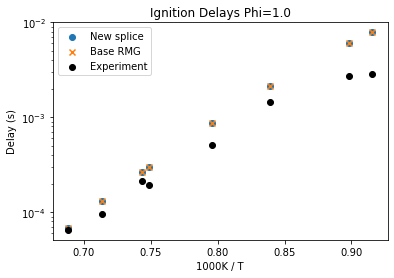

In [29]:
# plot the ignition delay
plt.scatter(1000.0 / T7, delays, marker='o')
# plt.plot(1000.0 / T7, small_core_rmg, marker='x')
# plt.plot(1000.0 / T7, no_libraries, marker='x')
plt.scatter(1000.0 / T7, base_rmg, marker='x')
# plt.plot(1000.0 / T7, aramco7, marker='x')
plt.scatter(1000.0 / T7, tau7, color='black')
ax = plt.gca()
ax.set_yscale('log')
plt.legend(['New splice', 'Base RMG', 'Experiment'])
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
# plt.legend(bbox_to_anchor=(0, 1), , ncol=1)

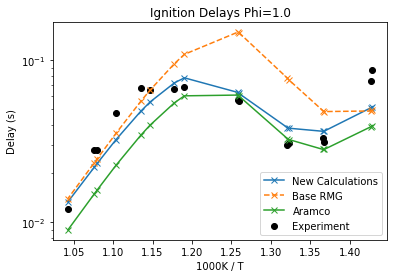

In [12]:
# plot the ignition delay
plt.plot(1000.0 / T7, delays, marker='x')
# plt.plot(1000.0 / T7, small_core_rmg, marker='x')
# plt.plot(1000.0 / T7, no_libraries, marker='x')
plt.plot(1000.0 / T7, base_rmg7, marker='x', linestyle='dashed')
plt.plot(1000.0 / T7, aramco7, marker='x')
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black')
ax = plt.gca()
ax.set_yscale('log')
plt.legend(['New Calculations', 'Base RMG', 'Aramco', 'Experiment'])
# plt.legend(['Only thermo 85 changed', 'Small Core RMG', 'No Libraries', 'Base RMG', 'Aramco', 'Experiment'], loc=(1.04, 0))
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
# plt.legend(bbox_to_anchor=(0, 1), , ncol=1)

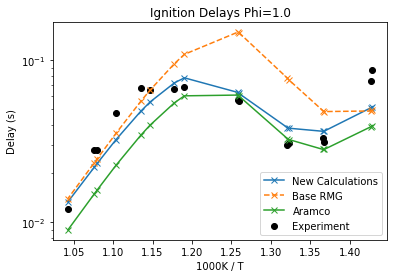

In [13]:
# plot the ignition delay
plt.plot(1000.0 / T7, delays, marker='x')
# plt.plot(1000.0 / T7, small_core_rmg, marker='x')
# plt.plot(1000.0 / T7, no_libraries, marker='x')
plt.plot(1000.0 / T7, base_rmg7, marker='x', linestyle='dashed')
plt.plot(1000.0 / T7, aramco7, marker='x')
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black')
ax = plt.gca()
ax.set_yscale('log')
plt.legend(['New Calculations', 'Base RMG', 'Aramco', 'Experiment'])
# plt.legend(['New Calculations', 'Small Core RMG', 'No Libraries', 'Base RMG', 'Aramco', 'Experiment'], loc=(1.04, 0))
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
# plt.legend(bbox_to_anchor=(0, 1), , ncol=1)

In [14]:
tau7

array([86.5 , 73.9 , 31.3 , 33.  , 30.9 , 30.  , 56.  , 56.6 , 67.9 ,
       66.4 , 65.2 , 67.1 , 47.  , 27.9 , 28.05, 12.  ])

In [15]:
delays[7]

0.06325180240998218

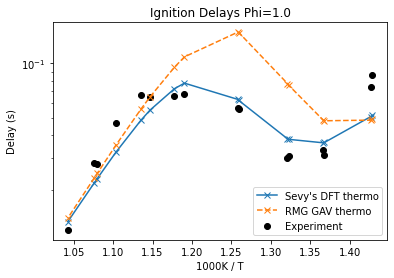

In [16]:
# plot the 
plt.plot(1000.0 / T7, delays, marker='x')
# plt.plot(1000.0 / T7, small_core_rmg, marker='x')
plt.plot(1000.0 / T7, base_rmg7, marker='x', linestyle='dashed')
# plt.plot(1000.0 / T7, aramco7, marker='x')
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black')
ax = plt.gca()
ax.set_yscale('log')
# plt.legend(['Mechanism 174', 'Base RMG', 'Aramco', 'Experiment'])
plt.legend(['Sevy\'s DFT thermo', 'RMG GAV thermo', 'Experiment'])
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')

In [17]:
print(gas.reactions()[832].rate)
print(gas.reactions()[833].rate)
print(gas.reactions()[834].rate)

Arrhenius(A=2.51e-14, b=6.77, E=-3.59824e+07)
Arrhenius(A=2.51e-14, b=6.77, E=-3.59824e+07)
Arrhenius(A=8.77928e-06, b=3.957, E=1.75268e+07)


In [18]:
print(gas.species()[85].thermo.coeffs)

[ 9.49210000e+02  1.16605865e+01  4.41236559e-02 -2.07772408e-05
  4.03962387e-09 -2.86276164e-13 -4.21917163e+04 -2.50449631e+01
  2.98377104e-02  9.31369094e-02 -9.82324541e-05  5.84404205e-08
 -1.46144596e-11 -3.99837532e+04  3.04602026e+01]


## Calculate Simple Linear Squared Error

In [19]:
def get_error(points):
    return np.dot(points - experiment7, points - experiment7)

In [20]:
print('Base RMG Error:\t', get_error(base_rmg7))
print('Aramco Error:\t', get_error(aramco7))
print('New Calc Error:\t', get_error(delays))

Base RMG Error:	 0.026513337786497698
Aramco Error:	 0.006378394111488899
New Calc Error:	 0.0028628940101847623


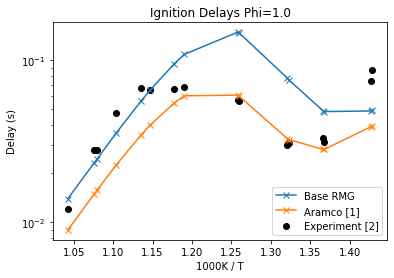

In [31]:
# plot the ignition delay
# plt.plot(1000.0 / T7, delays, marker='x')
# plt.plot(1000.0 / T7, small_core_rmg, marker='x')
# plt.plot(1000.0 / T7, no_libraries, marker='x')
plt.plot(1000.0 / T7, base_rmg7, marker='x')
plt.plot(1000.0 / T7, aramco7, marker='x')
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black')
ax = plt.gca()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.set_yscale('log')
plt.legend(['Base RMG', 'Aramco [1]', 'Experiment [2]'])
plt.annotate('Base RMG', (1,1))
# plt.legend(['New Calculations', 'Small Core RMG', 'No Libraries', 'Base RMG', 'Aramco', 'Experiment'], loc=(1.04, 0))
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
# plt.legend(bbox_to_anchor=(0, 1), , ncol=1)

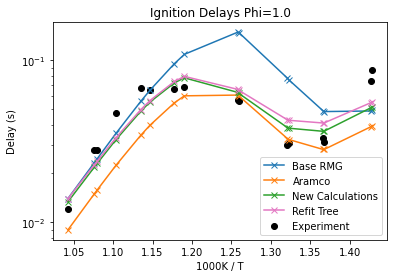

In [30]:
# plot the ignition delay
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(1000.0 / T7, base_rmg7, marker='x')
plt.plot(1000.0 / T7, aramco7, marker='x')
plt.plot(1000.0 / T7, delays, marker='x')
plt.plot(1000.0 / T7, refit_data, marker='x', color=colors[6])
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black')
ax = plt.gca()
ax.set_yscale('log')
plt.legend(['Base RMG', 'Aramco', 'New Calculations', 'Refit Tree', 'Experiment'])



# plt.annotate('Base RMG', (1.2, 0.2), color=colors[0], size=14)

# ax.annotate('Base RMG', xy=(1000.0 / T7[7], base_rmg7[7]),  xycoords='data',
#             xytext=(0.5, 0.2), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             horizontalalignment='right', verticalalignment='top',
#             )

# plt.legend(['New Calculations', 'Small Core RMG', 'No Libraries', 'Base RMG', 'Aramco', 'Experiment'], loc=(1.04, 0))
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
# plt.legend(bbox_to_anchor=(0, 1), , ncol=1)